In [1]:
from matplotlib  import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
######  CONSTANTS ######
### SETUP ###
training_rates = [1, 0.8, 0.5]
num_simulation = 10000

#--------- Risks -------- source: https://www.proofpoint.com/sites/default/files/gtd-pfpt-uk-tr-state-of-the-phish-2020-a4_final.pdf
phish_risk = 0.9
incidents_risk = {
    "Successfull Data Loss Attack": 0.55,
    "SuccessfullAccount Compromise" : 0.27,
    "Successfull Randsomeware Attack" : 0.49,
    "Other Successfull Malware Installation" : 0.38,
    "Successfull financial compromise" : 0.35
}

#--------- Variable risks --------
# source for rate : https://www.knowbe4.com/products/kevin-mitnick-security-awareness-training/
initial_click_rate = 0.379 # gaussian distributions centered here ...
click_sd = 0.1 # ... with this standard deviation
share_mean = 0.55  #gaussian distributions centered here ...
share_sd = 0.1 # ... with this standard deviation
# source for rate : fiting a curve through the graph from above
power = -0.85 # gaussian distributions centered here ...
deviation = 0.01 # ... with this standard deviation


In [3]:
def get_share_rate(initial_rate, exponent, share_risk, month, employee_training_rate):
    return employee_training_rate*initial_rate*pow(month, exponent)*share_risk + (1-employee_training_rate)*initial_rate
    
def fish_training_simulation(num_reps, employee_training_rate):
    exp = np.random.default_rng().normal(power, 0.01, num_reps)
    first_click_rate = np.random.default_rng().normal(initial_click_rate, click_sd, num_reps)
    share_risk =np.random.default_rng().normal(share_mean, share_sd, num_reps)
    df = pd.DataFrame({"function_exponent": exp,
                      "click_rate_before_traning":first_click_rate,
                      "share_rate": share_risk})
    
    
    for month in range(1,15):
        df["month_" + str(month)] =  df.apply(lambda row: get_share_rate(row['click_rate_before_traning'] , row['function_exponent'] , row['share_rate'], month, employee_training_rate), axis=1)
    
    risks_per_month = {}
    risk_per_type = {    
        "Successfull Data Loss Attack": [],
        "SuccessfullAccount Compromise" : [],
        "Successfull Randsomeware Attack" : [],
        "Other Successfull Malware Installation" : [],
        "Successfull financial compromise" : []
        }
    for month in range(1, 15):
        incident_proba = {}
        for inci, rate in incidents_risk.items():
            risk_per_type[inci].append(rate*df["month_" + str(month)].mean())
            incident_proba[inci] = rate*df["month_" + str(month)].mean() 
        risks_per_month["month_" + str(month)] = incident_proba
    return risk_per_type, risks_per_month

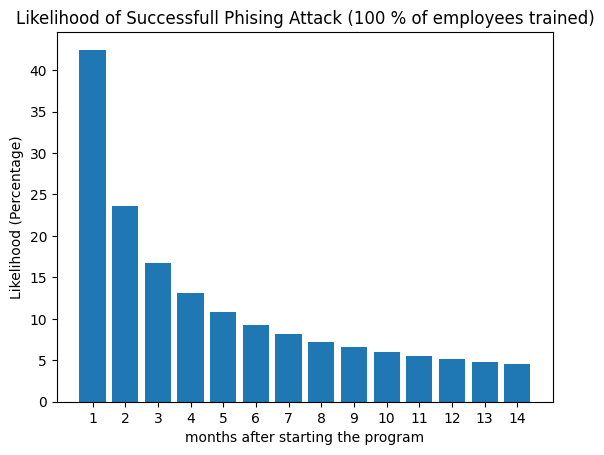

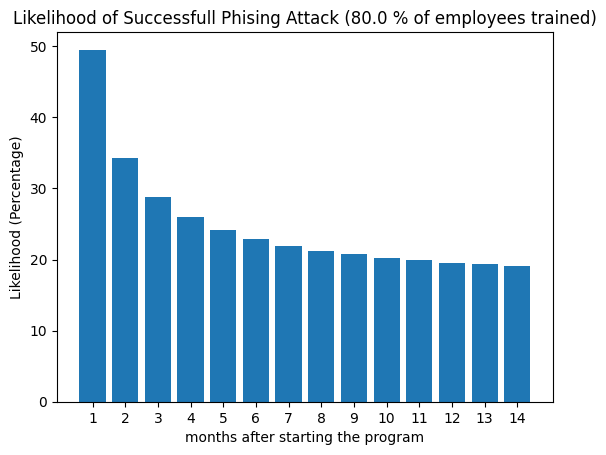

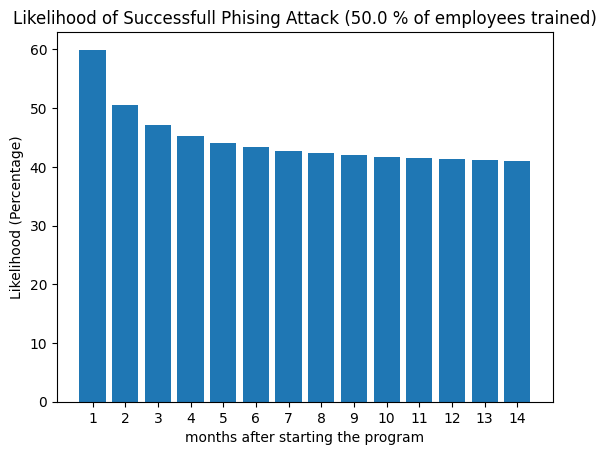

In [4]:
def graph(emp_train, risks):
    p_incidents_per_type, p_incidents_per_month = fish_training_simulation(num_simulation, emp_train)
    series = []
    plt.rcdefaults()
    if len(risks) == 1:
        series =  map(lambda value: value*100, p_incidents_per_type[risk])
        plt.title("Likelihood of " + str(risks) + "(" + str(emp_train*100) + " % of employees trained)")
    else:
        df = pd.DataFrame.from_dict(p_incidents_per_type)
        risk_prob = df.sum(axis=1).values.tolist()
        series = list(map(lambda value: value*100, risk_prob))
        plt.title("Likelihood of Successfull Phising Attack (" + str(emp_train*100) + " % of employees trained)")

    labels = range(1, len(p_incidents_per_month)+1)
    plt.bar(labels, series, tick_label = labels,linewidth = 2)
    plt.xlabel('months after starting the program')
    plt.ylabel('Likelihood (Percentage)')
    plt.show()

for i in training_rates:
    graph(i, incidents_risk.keys())

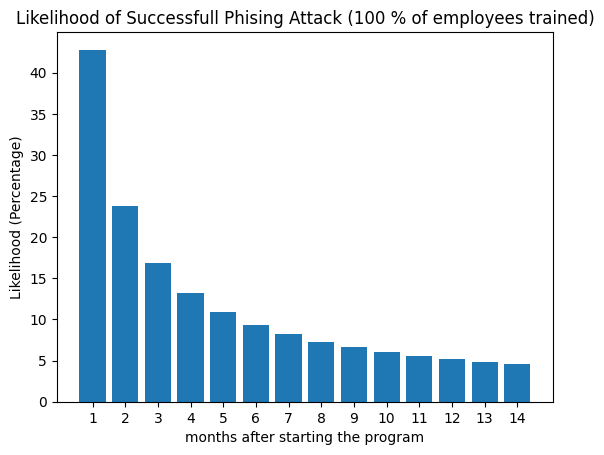

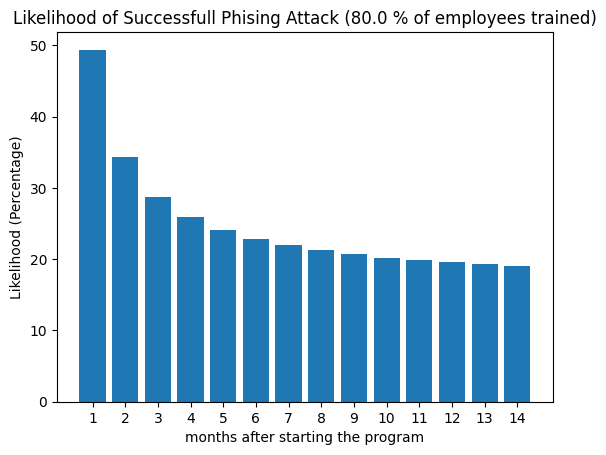

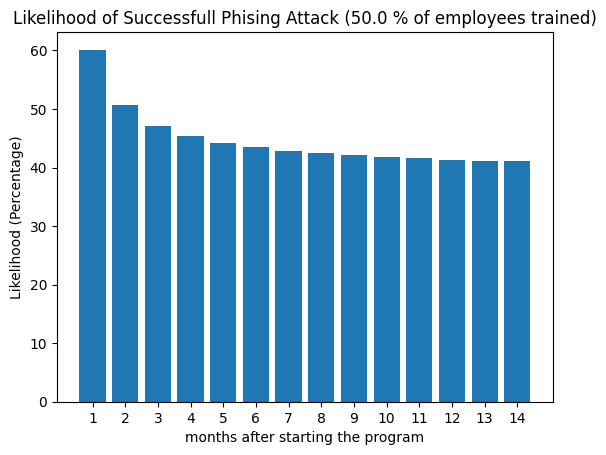

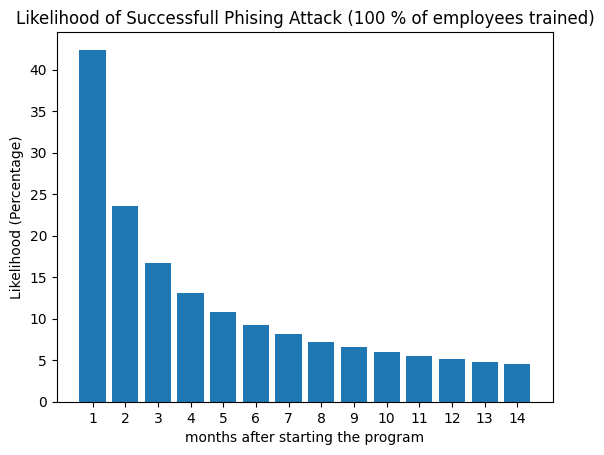

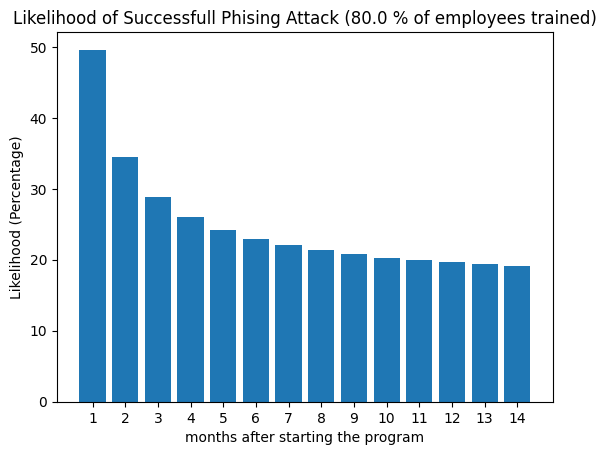

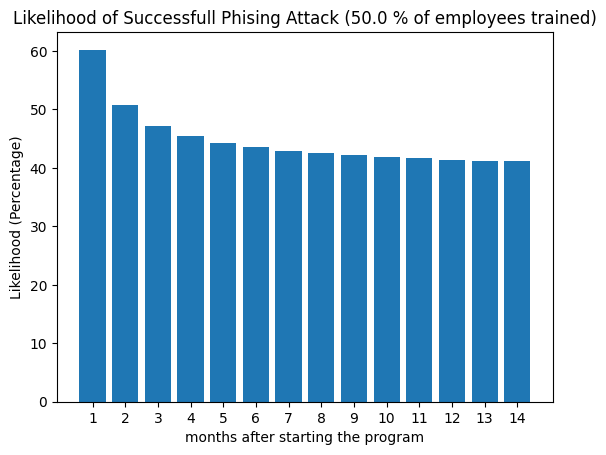

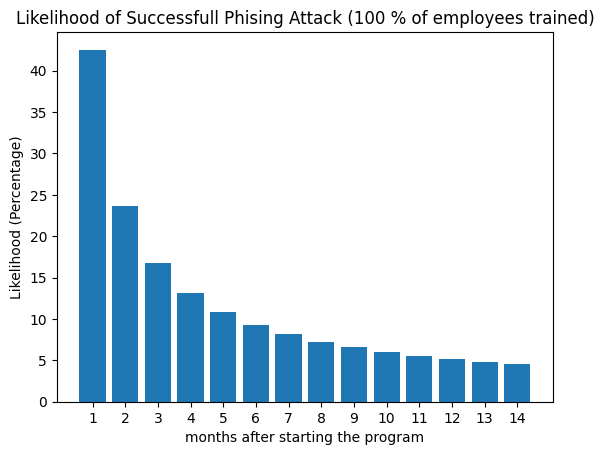

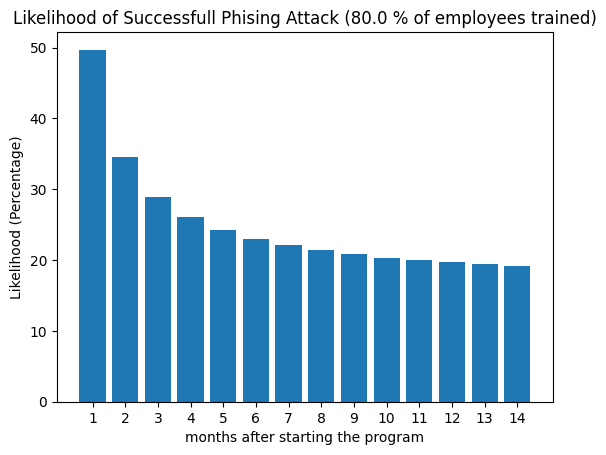

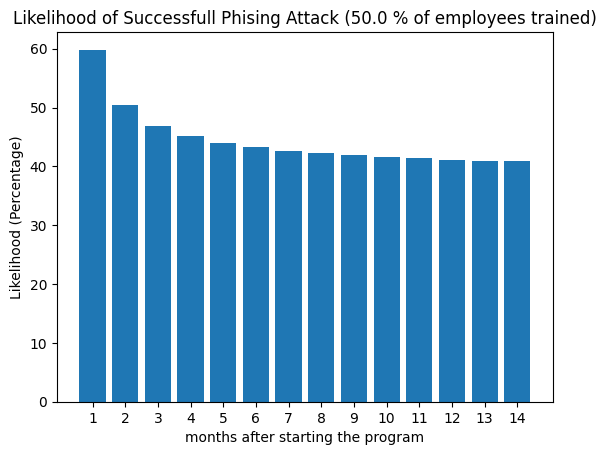

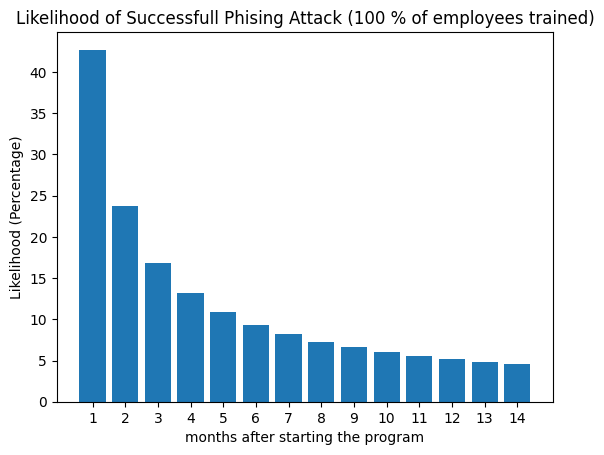

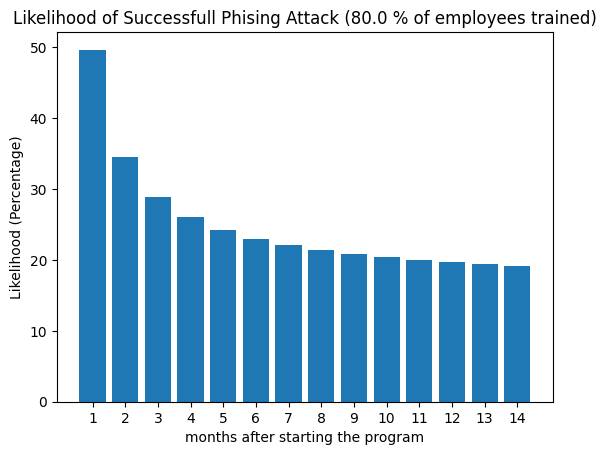

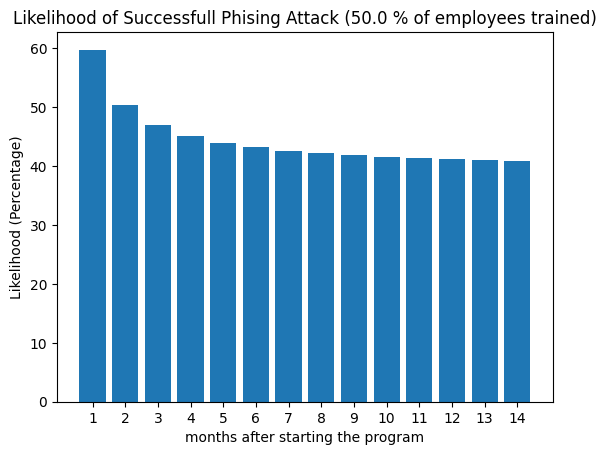

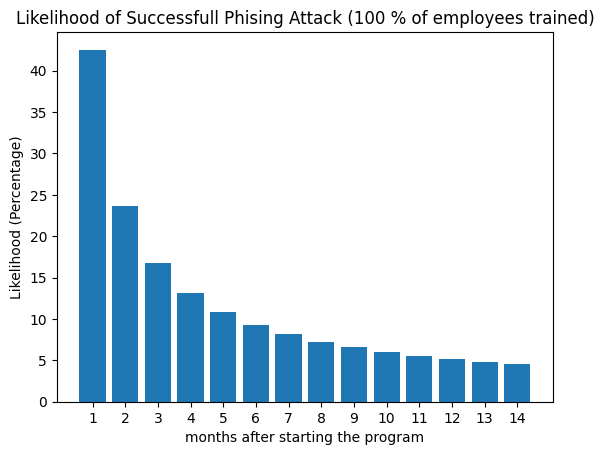

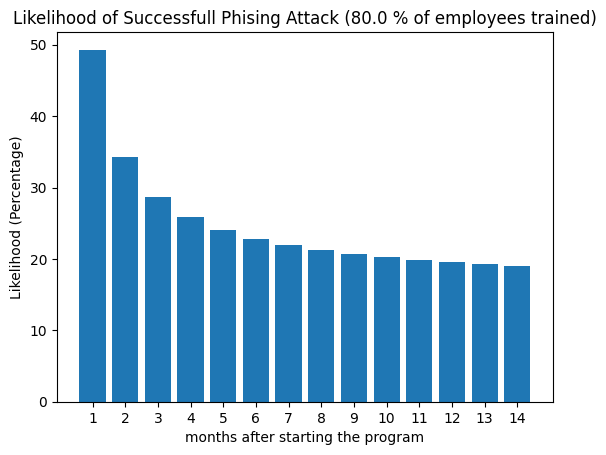

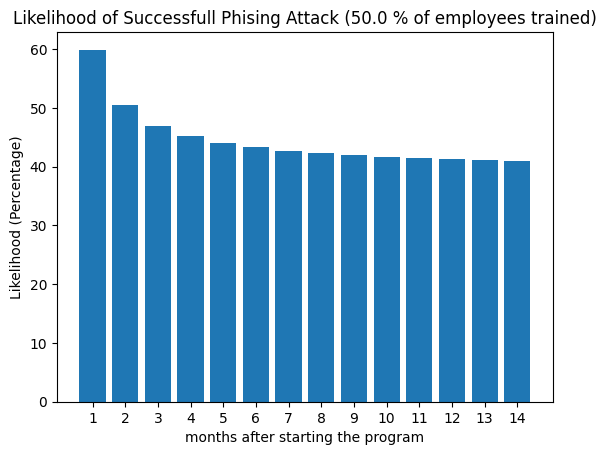

In [5]:
for risk in incidents_risk.keys():
    for i in training_rates:
        graph(i, risk)
